In [191]:
import sys
from pathlib import Path
import pandas as pd 
import numpy as np
import keras
from keras.layers import LSTM, Dense, Dropout, LeakyReLU, GRU, BatchNormalization,  Flatten, MaxPooling2D, TimeDistributed, ConvLSTM1D, Input
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
sys.path.append(str(Path("../../..").resolve()))
from src.constants import model_data_dir


In [ ]:
df = pd.read_csv(model_data_dir / "train_classification.csv")
df

In [103]:
remove_cols = ["sc_1d_fwd_rel_d", "mom_1d_fwd_rel_d"]

df_train = pd.read_csv(model_data_dir / "train_classification.csv").drop(remove_cols + ["Date"], axis=1)
df_test = pd.read_csv(model_data_dir / "test_classification.csv").drop(remove_cols, axis=1)
test_dates = pd.to_datetime(df_test["Date"])
df_test.drop("Date", axis=1, inplace=True)

In [104]:
((y_train, x_train), (y_test, x_test)) = ((df_train.pop("value_1d_fwd_rel_d"), df_train), (df_test.pop("value_1d_fwd_rel_d"), df_test))

In [138]:
win_length = 14
batch_size = 180
num_features = x_train.shape[1]
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)


## LSTM

In [194]:
model = Sequential()
model.add(Input(shape=(win_length, num_features)))
model.add(LSTM(256, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(LSTM(128, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(LSTM(64, return_sequences=True, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2)) 
model.add(LSTM(32, return_sequences=False, bias_initializer="zeros", unit_forget_bias=True))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Dense(1, activation="sigmoid"))

In [195]:
early_stop = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                            patience = 20)

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer="adam",
              metrics=["accuracy"])

history = model.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stop])

Epoch 1/50
19/19 [==============================] - 12s 196ms/step - loss: 0.6919 - accuracy: 0.5405 - val_loss: 0.6952 - val_accuracy: 0.4893
Epoch 2/50
19/19 [==============================] - 2s 103ms/step - loss: 0.6782 - accuracy: 0.5731 - val_loss: 0.7203 - val_accuracy: 0.4995
Epoch 3/50
19/19 [==============================] - 2s 105ms/step - loss: 0.6569 - accuracy: 0.6152 - val_loss: 0.7378 - val_accuracy: 0.4931
Epoch 4/50
19/19 [==============================] - 2s 101ms/step - loss: 0.6354 - accuracy: 0.6390 - val_loss: 0.7601 - val_accuracy: 0.5059
Epoch 5/50
19/19 [==============================] - 2s 102ms/step - loss: 0.6186 - accuracy: 0.6610 - val_loss: 0.7597 - val_accuracy: 0.5160
Epoch 6/50
19/19 [==============================] - 2s 105ms/step - loss: 0.6171 - accuracy: 0.6572 - val_loss: 0.8389 - val_accuracy: 0.5096
Epoch 7/50
19/19 [==============================] - 2s 103ms/step - loss: 0.6114 - accuracy: 0.6695 - val_loss: 0.8207 - val_accuracy: 0.5182
Epoch

In [133]:
predictions = model.predict_generator(test_generator)
df_preds = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds["yhat"] = predictions.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/953353012.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


<AxesSubplot:>

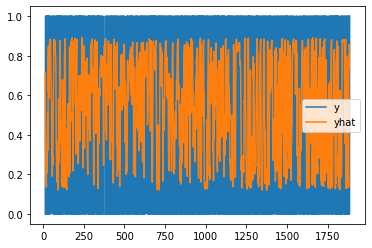

In [134]:
df_preds[["y", "yhat"]].plot()

## GRU 

In [124]:
model_gru = Sequential()
model_gru.add(GRU(256, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(GRU(128, input_shape= (win_length, num_features), return_sequences=True))
model_gru.add(LeakyReLU(alpha=0.5)) 
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(LSTM(32, input_shape= (win_length, num_features), return_sequences=False))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.3)) 
model_gru.add(Dense(1, activation="sigmoid"))

In [125]:
early_stop_gru = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                               patience = 20)

model_gru.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history_gru = model_gru.fit(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False, callbacks=[early_stop_gru])

Epoch 1/50
38/38 [==============================] - 14s 104ms/step - loss: 0.9734 - accuracy: 0.4924 - val_loss: 0.7009 - val_accuracy: 0.4845
Epoch 2/50
38/38 [==============================] - 3s 69ms/step - loss: 0.7638 - accuracy: 0.5740 - val_loss: 0.7109 - val_accuracy: 0.4850
Epoch 3/50
38/38 [==============================] - 2s 65ms/step - loss: 0.7144 - accuracy: 0.6061 - val_loss: 0.7075 - val_accuracy: 0.4947
Epoch 4/50
38/38 [==============================] - 3s 68ms/step - loss: 0.6707 - accuracy: 0.6322 - val_loss: 0.7208 - val_accuracy: 0.4936
Epoch 5/50
38/38 [==============================] - 3s 76ms/step - loss: 0.6447 - accuracy: 0.6560 - val_loss: 0.7402 - val_accuracy: 0.4925
Epoch 6/50
38/38 [==============================] - 3s 78ms/step - loss: 0.6204 - accuracy: 0.6683 - val_loss: 0.7586 - val_accuracy: 0.4866
Epoch 7/50
38/38 [==============================] - 3s 77ms/step - loss: 0.6187 - accuracy: 0.6707 - val_loss: 0.7795 - val_accuracy: 0.4781
Epoch 8/50


In [126]:
predictions_gru = model_gru.predict_generator(test_generator)
df_preds_gru = pd.DataFrame({"ds": test_dates[win_length:], "y": y_test[win_length:], })
df_preds_gru["yhat"] = predictions_gru.flatten()

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/2811852203.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


<AxesSubplot:>

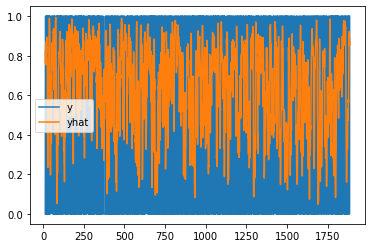

In [127]:
df_preds_gru[["y", "yhat"]].plot()

In [128]:
predictions_gru = model_gru.predict_generator(test_generator)

/var/folders/r2/ycy8hp_54yd7bxc_0kyb5trm0000gn/T/ipykernel_73342/303773502.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions_gru = model_gru.predict_generator(test_generator)


In [129]:
preds = predictions_gru.flatten()
(np.where(preds > 0.5, 1, 0) == y_test[win_length:]).mean()

0.48504273504273504